# PFN and PFN with mdn layer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time as t
import scipy.constants as spc
import matplotlib.ticker as ticker


In [2]:
path_prefix = 'D:/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
ext_path = "H:/EPE_file_storage/"
ext_modelpath = ext_path + "Model/"
ext_datapath = ext_path + "data_storage/STMC/"
ext_plotpath = ext_path + "plots/"

In [3]:
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

In [4]:
def tvt_num(_data, _tvt=(75, 10, 15)):
    ''' Function designed to output appropriate numbers for traning validation and testing given
    a variable length input. TVT expressed as ratios and do not need to add to 100. '''
    _tot = len(_data)
    _train, _val, _test = _tvt
    _tvt_sum = _train + _val + _test
    
    _train_rtrn = round(_train*_tot/_tvt_sum)
    _val_rtrn = round(_val*_tot/_tvt_sum)
    _test_rtrn = _tot - _train_rtrn - _val_rtrn
    
    return _train_rtrn, _val_rtrn, _test_rtrn

def normalize_input1d(arr, mask):
    ''' Note that non masked values are left alone i.e. zeros if mask = arr != 0'''
    len_arr = arr.shape[0]
    mean = np.repeat(np.mean(arr, where=mask), len_arr)
    std_dev = np.repeat(np.std(arr, where=mask), len_arr)
    norm_arr = np.subtract(arr, mean, out=arr, where=mask)
    std_mask = np.logical_and(std_dev!=0, mask)
    norm_arr = np.divide(norm_arr, std_dev, out=norm_arr, where=std_mask)
    return norm_arr

def normalize_input2d(arr, mask):
    ''' Truth value is where to perform the operation, exclude False vals.
    returns: Array with the shape of arr with normalization carried out with mask '''
    len_ax1 = arr.shape[1]
    mean = np.tile(np.mean(arr, axis=1, where=mask), (len_ax1,1)).transpose()
    std_dev = np.tile(np.std(arr, axis=1, where=mask), (len_ax1,1)).transpose()
    norm_arr = np.subtract(arr, mean, out=arr, where=mask)
    std_mask = np.logical_and(std_dev != 0, mask)
    norm_arr = np.divide(norm_arr, std_dev, out=norm_arr, where=std_mask)
    return norm_arr

def eval_generator(data, batch_size):
     batches = (len(data) + batch_size - 1)//batch_size
     for i in range(batches):
          X = data[i*batch_size : (i+1)*batch_size]
          yield (X)

In [5]:
import scipy.stats as stats
# from . import plot_util as pu
from util import plot_util as pu

def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))

def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1), 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution

In [29]:
# load STMC numpy file

Nfile = 5
fileNames = []
for i in range(1,Nfile+1):
    fileNames.append(ext_datapath + 'STMC_' + str(i) + '.npz')

X = []
Y = []
for fname in fileNames:
    file = np.load(fname)
    file_X = file.f.x
    file_Y = file.f.y
    X.append(file_X)
    Y.append(file_Y)
Xraw = np.concatenate(X,axis=0)
Yraw = np.concatenate(Y,axis=0)

In [ ]:
X = np.lib.format.open_memmap(ext_datapath + "stmc_X_"+ str(Nfile)+"f.npy",
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 5))
np.copyto(dst=X, src=Xraw[:,:,:5], casting='same_kind', where=True)

Y = np.lib.format.open_memmap(ext_datapath + "stmc_Y_"+ str(Nfile)+"f.npy",
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0]))
np.copyto(dst=Y, src=Yraw[:,0], casting='same_kind', where=True)

print(X.shape)
print(Y.shape)

In [7]:
# Or load data from mmap
X = np.load(ext_datapath + "stmc_X_3f_2.npy", mmap_mode="r+")
Y = np.load(ext_datapath + "stmc_Y_3f_2.npy", mmap_mode="r+")

In [12]:
# for PFN approach Y normalization
# the target energy values
# target_zero_mask, Y : 0 for truthPartE, 1 for truthTrackPt, 2 for cluster_eng_clib_tot
target_zero_mask = Y > .05
Ylog = np.log(Y[target_zero_mask])
print('Any targets below 50 GeV: '+str(np.count_nonzero(np.invert(target_zero_mask))))
print('Number of events: '+str(len(Y)))

Any targets below 50 GeV: 0
Number of events: 205980


In [13]:
t0 = t.time()
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

isnan = np.isnan(X[:,:,0])
anytruth = np.any(isnan)
print(anytruth)

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[:,:,2][phi_mask])
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std
t1 = t.time()
print('Time to Normalize: '+str(t1-t0)+' (s)')

False
Time to Normalize: 73.94576001167297 (s)


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
import keras.backend as Kb
import energyflow as ef
from energyflow.archs import PFN

In [ ]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = tvt_num(X, _tvt=(85, 5, 10))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1500
batch_size = 1000

netOpt = tf.keras.optimizers.Adam(
    learning_rate=.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

RMS_prop = tf.keras.optimizers.RMSprop(learning_rate=0.001)

In [16]:
# dataset = tf.data.Dataset.from_tensor_slices((X, Y))
(x_train, x_val, x_test,
 y_train, y_val, y_test) = ef.utils.data_split(X, Ylog, val=val, test=test)

# Print out tensor shapes
print(np.shape(x_train))
print(np.shape(y_train))

(175083, 1086, 5)
(175083,)


In [13]:
Kb.clear_session()

pfn = PFN(input_dim=5, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss,
          optimizer=netOpt, metrics=[])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [14]:
chkpoint = tf.keras.callbacks.ModelCheckpoint(ext_modelpath + 'pfn_regressor_5f.h5', monitor='val_loss', verbose=1, save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=150, verbose=0, restore_best_weights=True)
t0 = t.time()
history_ct = pfn.fit(x_train, y_train,
        epochs=1000,
        batch_size=800,
        validation_data=(x_val, y_val),
        verbose=1,
        callbacks=[chkpoint, earlystop])
t1 = t.time()

Epoch 1/1000
219/219 [==============================] - 20s 69ms/step - loss: 370.3499 - val_loss: 1.4737

Epoch 00001: val_loss improved from inf to 1.47368, saving model to H:/EPE_file_storage/Model\pfn_regressor_5f.h5
Epoch 2/1000
219/219 [==============================] - 14s 63ms/step - loss: 1.0992 - val_loss: 0.7904

Epoch 00002: val_loss improved from 1.47368 to 0.79043, saving model to H:/EPE_file_storage/Model\pfn_regressor_5f.h5
Epoch 3/1000
219/219 [==============================] - 14s 63ms/step - loss: 0.6866 - val_loss: 0.7606

Epoch 00003: val_loss improved from 0.79043 to 0.76058, saving model to H:/EPE_file_storage/Model\pfn_regressor_5f.h5
Epoch 4/1000
219/219 [==============================] - 14s 62ms/step - loss: 0.6726 - val_loss: 0.4474

Epoch 00004: val_loss improved from 0.76058 to 0.44735, saving model to H:/EPE_file_storage/Model\pfn_regressor_5f.h5
Epoch 5/1000
219/219 [==============================] - 14s 62ms/step - loss: 0.5240 - val_loss: 0.4186

Epoch

In [15]:
preds = np.exp(pfn.predict(eval_generator(x_test,500)).flatten())
print(preds.shape)

(20598,)


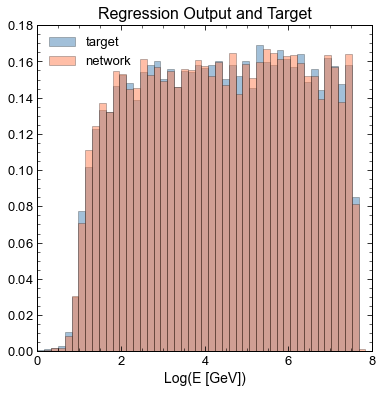

In [16]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(y_test, color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(np.log(preds), color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_targetPreds_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

<Figure size 799.992x599.976 with 0 Axes>

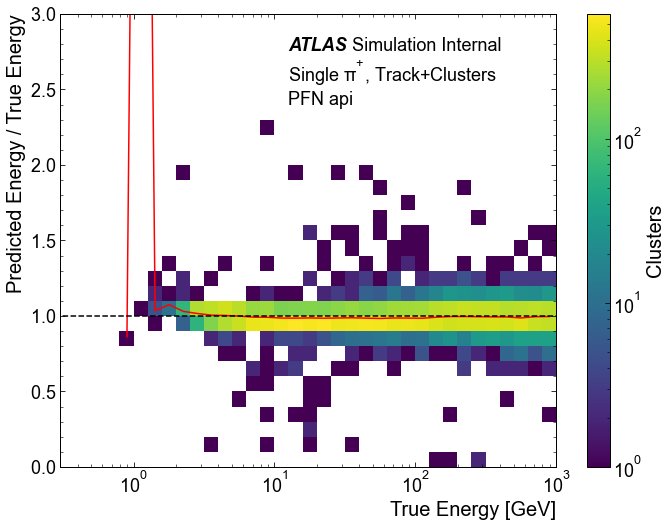

In [17]:
xcenter, medDNN = ru.responsePlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, Track+Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'PFN api'}])

In [9]:
import scipy.stats as stats
# from . import plot_util as pu
from util import plot_util as pu

def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))

def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1), 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution

<Figure size 799.992x599.976 with 0 Axes>

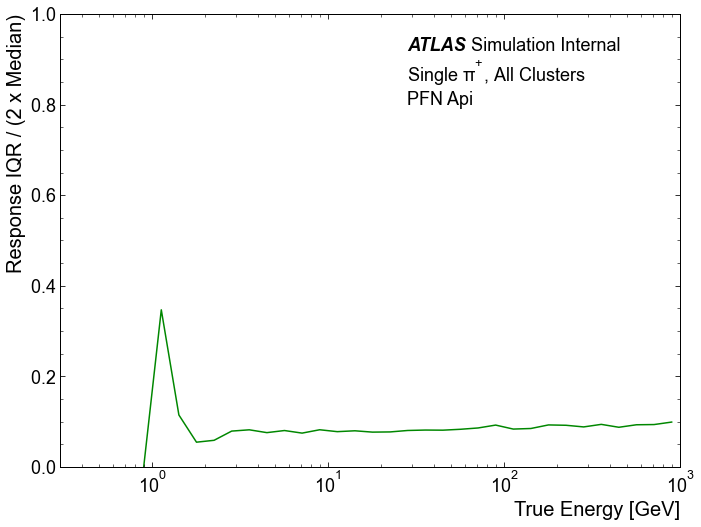

In [19]:
xcenter, iqrMDN3 = resolutionPlot(np.exp(y_test), preds,
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN Api'}])

In [11]:
import tensorflow_probability as tfp

In [10]:
def point_mask_fn(X, mask_val=0.):
    return Kb.cast(Kb.any(Kb.not_equal(X, mask_val), axis=-1), Kb.dtype(X))

def convert_to_tensor(X):
    return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)

def ParticleFlow_MDN(num_features, name="PFN_MDN_Network"):
    
    event_shape = [1]
    num_components = 3
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)


    inputs = keras.Input(shape=(None, num_features), name='input')

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    
    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.))(activation_5)

    
    mdn_0 = tfp.layers.MixtureNormal(num_components, event_shape, validate_args=True,
                                          convert_to_tensor_fn=convert_to_tensor)(dense_6)
    
    return keras.Model(inputs=inputs, outputs=mdn_0, name=name)

In [12]:
Kb.clear_session()

netOpt = tf.keras.optimizers.Adam(
    learning_rate=.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

PFN_mdn = ParticleFlow_MDN(num_features=5)
PFN_mdn.compile(optimizer = netOpt, loss="mse")
PFN_mdn.summary()

Model: "PFN_MDN_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation_0 (Activation)       (None, None, 100)    0           t_dist_0[0][0]                   
__________________________________________________________________________________________________
t_dist_1 (TimeDistributed)      (None, None, 100)    10100       activation_0[0][0]               
____________________________________________________________________________________

In [13]:
chkpoint = tf.keras.callbacks.ModelCheckpoint(ext_modelpath + 'PFN_MDN_regressor_weight_1.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=150, verbose=0, restore_best_weights=True)
t0 = t.time()
history_ct = PFN_mdn.fit(x_train, y_train,
        epochs=1000,
        batch_size=600,
        validation_data=(x_val, y_val),
        verbose=1,
        callbacks=[chkpoint, earlystop])
t1 = t.time()

Epoch 1/1000
292/292 [==============================] - 16s 41ms/step - loss: 0.6217 - val_loss: 0.0534

Epoch 00001: val_loss improved from inf to 0.05337, saving model to H:/EPE_file_storage/Model\PFN_MDN_regressor_weight_1.h5
Epoch 2/1000
292/292 [==============================] - 11s 38ms/step - loss: 0.0520 - val_loss: 0.0370

Epoch 00002: val_loss improved from 0.05337 to 0.03701, saving model to H:/EPE_file_storage/Model\PFN_MDN_regressor_weight_1.h5
Epoch 3/1000
292/292 [==============================] - 11s 38ms/step - loss: 0.0361 - val_loss: 0.0262

Epoch 00003: val_loss improved from 0.03701 to 0.02621, saving model to H:/EPE_file_storage/Model\PFN_MDN_regressor_weight_1.h5
Epoch 4/1000
292/292 [==============================] - 11s 37ms/step - loss: 0.0297 - val_loss: 0.0240

Epoch 00004: val_loss improved from 0.02621 to 0.02402, saving model to H:/EPE_file_storage/Model\PFN_MDN_regressor_weight_1.h5
Epoch 5/1000
292/292 [==============================] - 11s 37ms/step - 

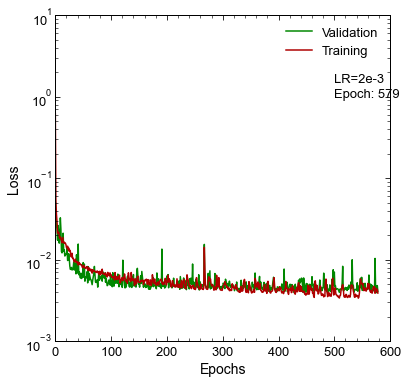

In [17]:
fig = plt.figure(figsize=(6,6))
plt.plot(history_ct.history['val_loss'], label="Validation")
plt.plot(history_ct.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,600)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(500, 1.5, 'LR=2e-3', fontsize=13)
plt.text(500, 1, 'Epoch: 579', fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_lossCurves_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

In [20]:
preds = np.exp(PFN_mdn.predict(eval_generator(x_test,500)))
print(preds.shape)

(20598, 2)


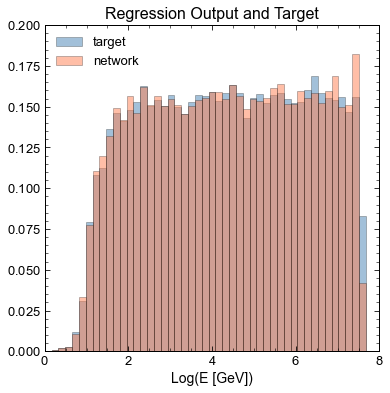

In [21]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(y_test, color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(np.log(preds[:,0]), color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_targetPreds_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

<Figure size 799.992x599.976 with 0 Axes>

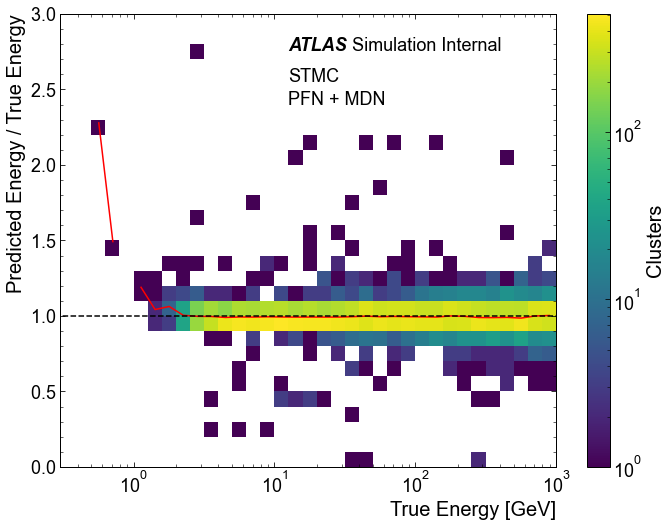

In [26]:
xcenter, medDNN = ru.responsePlot(x=np.exp(y_test), y=preds[:,0]/np.exp(y_test),
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'STMC'},
                             {'x': 0.46, 'y': 0.8,  'text': 'PFN + MDN'}])

<Figure size 799.992x599.976 with 0 Axes>

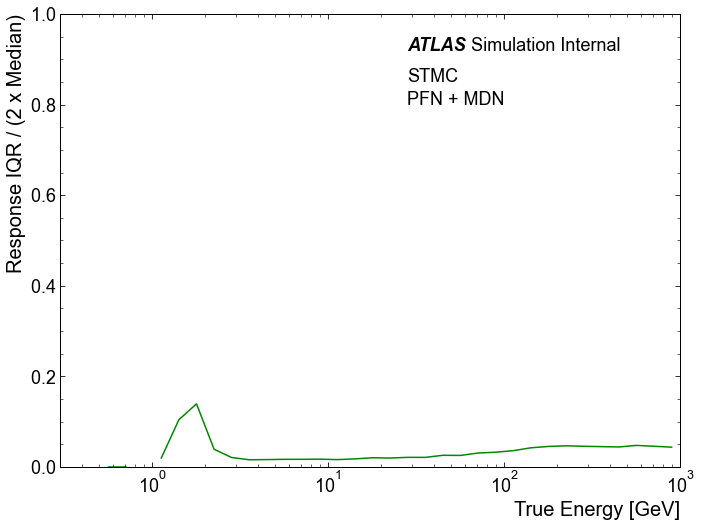

In [25]:
xcenter, iqrMDN3 = resolutionPlot(x=np.exp(y_test), y=preds[:,0]/np.exp(y_test),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'STMC'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN + MDN'}])